In [1]:
# multivariate multi-step data preparation
from numpy import array
from numpy import hstack
import pandas as pd
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR


c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
dades = read_csv('dadesBaellsMulti.csv', sep=';',header=0, index_col=0)

vol = dades['Volum']
tm = dades['TM']
hrm = dades['HRM']
ppt = dades['PPT']
pm = dades['PM']

# convert to [rows, columns] structure
vol = vol.reshape((len(vol), 1))
tm = tm.reshape((len(tm), 1))
hrm = hrm.reshape((len(hrm), 1))
ppt = ppt.reshape((len(ppt), 1))
pm = pm.reshape((len(pm), 1))


# horizontally stack columns
dataset = hstack((vol,tm,hrm,ppt,pm,vol))

scaler = MinMaxScaler(feature_range=(0, 1))
datasetN = scaler.fit_transform(dataset)

c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  de

In [3]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [4]:
def train_test (n_steps_in, n_steps_out, propTrainTest, dataset):
    
    n_steps_in, n_steps_out = n_steps_in, n_steps_out
    # split train test
    X, y = split_sequences(dataset, n_steps_in, n_steps_out)
    
    train_size = int(len(X) * propTrainTest)
    test_size = len(dataset) - train_size
    train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]
    train_Y, test_Y = y[0:train_size,:], y[train_size:len(y),:]
    
    return (train_X, test_X, train_Y, test_Y)

In [5]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calcul global de RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [6]:
n_steps_in = 20
n_steps_out = 15
propTrainTest = 0.8
train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, datasetN)

In [7]:
# flatten input
n_input = train_X.shape[1] * train_X.shape[2]
train_X = train_X.reshape((train_X.shape[0], n_input))
test_X = test_X.reshape((test_X.shape[0], n_input))

In [14]:
from scipy.stats import uniform
from scipy.stats import randint
c=[]
epsilon=[]
gamma=[]
num_repeticions=500
for i in range(num_repeticions):
    c.append((randint.rvs(5, 125)))
    epsilon.append(round(uniform.rvs(0.0001, 0.1),4))
    gamma.append(round(uniform.rvs(0.01, 0.9),4))
    



In [11]:
#Cerca optimització aleatòria de 500 combinacions de paràmetres
resultat=[]

for c_v, eps, gam in zip(c, epsilon, gamma):
    regr_multisvr = MultiOutputRegressor(SVR(kernel='rbf', C=c_v, gamma=gam, epsilon=eps))
    regr_multisvr.fit(train_X, train_Y)
    # Predict on new data
    yhat = regr_multisvr.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
    # invertim prediccions per tenir-les en l'escala original
    yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
    test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
    #dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    inv_yhat = scaler.inverse_transform(dataset2)
    testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
    #test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
    test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])

    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT,c_v,gam,eps)
    resultat.append((c_v, gam, eps, RMSE_days,RMSE_TOT))
                 
    

3.6372351464464323 99 0.1449 0.0247
3.7574244048144965 67 0.1754 0.0002
6.676833696762301 103 0.8635 0.087
3.6292422077563264 69 0.3441 0.0316
5.179835401254266 120 0.4228 0.0869
4.8958519984573305 114 0.3204 0.0878
3.8371969608650756 38 0.3216 0.0465
3.539981561485384 13 0.3897 0.0051
3.6068926287453884 100 0.1628 0.0167
4.467575654239632 88 0.0535 0.082
5.1644050204523975 72 0.3737 0.0919
4.295659728870553 117 0.224 0.071
4.667738249826397 100 0.4432 0.0683
5.067620079003418 61 0.8632 0.0235
5.136533068616463 46 0.5828 0.0705
5.317216137049391 31 0.7344 0.0583
4.553521545814442 36 0.2452 0.0807
3.780307094424046 102 0.0162 0.062
5.615908704805829 23 0.5181 0.0923
3.5834201489117743 87 0.4221 0.0087
4.4279036068314905 18 0.6921 0.0241
6.2708322236220955 54 0.7213 0.0914
3.5167968750298573 9 0.3507 0.0114
3.6738014892717743 47 0.1884 0.0364
3.8792214921339685 27 0.2373 0.0509
4.902473493383298 20 0.6581 0.0536
6.489992284821568 70 0.7545 0.0944
3.777244725469759 121 0.1355 0.0387
3.587

3.9897213633115616 91 0.2782 0.0549
4.659820269881078 41 0.5535 0.0578
4.574782864550162 85 0.2605 0.0807
3.775118791095693 53 0.4227 0.0322
3.643118137171451 63 0.3363 0.0338
3.773013683887917 19 0.3256 0.0431
3.512979264706974 69 0.3304 0.0036
5.598916519992342 31 0.7746 0.0628
4.4339063566609385 24 0.5122 0.0541
4.3888368873116175 99 0.5951 0.0406
3.5333619111772565 75 0.2063 0.0212
4.617812403264637 60 0.8065 0.0005
3.9076201753966537 27 0.5439 0.0188
3.559360739371728 80 0.2186 0.0294
4.106790298094159 53 0.5271 0.0367
5.101060563378136 107 0.3027 0.0956
4.930000498196115 30 0.6958 0.0491
4.171267015705533 111 0.0744 0.0655
5.126090809732278 76 0.6325 0.0648
4.045266263416342 55 0.0641 0.0552
3.053017176077539 105 0.0196 0.0295
3.7887579741024675 99 0.0981 0.0352
5.759013043567927 52 0.5219 0.0967
5.022317875955483 103 0.5256 0.0724
4.318481710556555 82 0.7174 0.0055
5.927398819834677 69 0.7596 0.0761
3.518684807770951 119 0.3634 0.0062
3.919559637977714 121 0.3614 0.0477
4.507343

4.362940747836701 103 0.7116 0.0137
3.595637362652804 82 0.365 0.0247
3.717352609794862 52 0.4845 0.0132
4.1642891236451804 100 0.6624 0.0099
3.7446839918512596 45 0.1719 0.0013
4.975625185471181 12 0.4581 0.0769
4.144421998197546 92 0.4723 0.0467
3.7307477083162643 92 0.3751 0.0359
3.59788832487824 102 0.2935 0.0335
3.836445405808875 18 0.4476 0.0327
4.331140768315569 44 0.6555 0.0259
4.0650483710633605 59 0.5658 0.0269
4.957938296808905 89 0.5494 0.0681
5.368726528336216 117 0.8583 0.0395
4.216059159004123 71 0.2959 0.0633
4.761905175446186 32 0.2526 0.0875
4.655537047098196 107 0.0364 0.0914
4.5736831064243315 110 0.3426 0.0732
5.050318662211934 61 0.8708 0.0203
4.064601999542375 31 0.3556 0.054
4.347467262482403 32 0.5518 0.0454
4.182356341484552 72 0.3012 0.0616
4.043229313535459 63 0.1358 0.0591
3.9878318912753064 122 0.5221 0.0301
3.973949432324368 103 0.4083 0.046
5.275331403193525 33 0.7097 0.0603
4.761501491252561 18 0.7885 0.023
6.069718533038741 77 0.8102 0.0742
6.442016343

In [24]:
resultatAux=[(3.6372351464464323,99,0.1449,0.0247 ), 
(3.7574244048144965,67,0.1754,0.0002 ),
(6.676833696762301,103,0.8635,0.087  ),
(3.6292422077563264,69,0.3441,0.0316 ),
(5.179835401254266,120,0.4228,0.0869 ),
(4.8958519984573305,114,0.3204,0.0878),
(3.8371969608650756,38,0.3216,0.0465 ),
(3.539981561485384,13,0.3897,0.0051  ),
(3.6068926287453884,100,0.1628,0.0167),
(4.467575654239632,88,0.0535,0.082   ),
(5.1644050204523975,72,0.3737,0.0919 ),
(4.295659728870553,117,0.224,0.071   ),
(4.667738249826397,100,0.4432,0.0683 ),
(5.067620079003418,61,0.8632,0.0235  ),
(5.136533068616463,46,0.5828,0.0705  ),
(5.317216137049391,31,0.7344,0.0583  ),
(4.553521545814442,36,0.2452,0.0807  ),
(3.780307094424046,102,0.0162,0.062  ),
(5.615908704805829,23,0.5181,0.0923  ),
(3.5834201489117743,87,0.4221,0.0087 ),
(4.4279036068314905,18,0.6921,0.0241 ),
(6.2708322236220955,54,0.7213,0.0914 ),
(3.5167968750298573,9,0.3507,0.0114  ),
(3.6738014892717743,47,0.1884,0.0364 ),
(3.8792214921339685,27,0.2373,0.0509 ),
(4.902473493383298,20,0.6581,0.0536  ),
(6.489992284821568,70,0.7545,0.0944  ),
(3.777244725469759,121,0.1355,0.0387 ),
(3.587725676522437,20,0.1952,0.0101  ),
(4.0591194952002,90,0.2428,0.0594    ),
(4.808302891277995,61,0.2382,0.0894  ),
(3.817447319297396,15,0.1265,0.041   ),
(5.713427335136207,37,0.8297,0.0585  ),
(3.710506295015076,123,0.5039,0.0031 ),
(4.158860488664283,49,0.6315,0.0189  ),
(3.5042021344055327,13,0.2633,0.0135 ),
(5.098749822476376,54,0.4497,0.0816  ),
(4.921900101403263,56,0.4492,0.0759  ),
(3.888913833071763,21,0.4154,0.0408  ),
(3.9096444349823023,23,0.5133,0.026  ),
(4.224977927718246,118,0.3754,0.0586 ),
(3.503234581205804,102,0.2619,0.0204 ),
(3.522678660145056,53,0.364,0.0039   ),
(3.53159407510964,20,0.3754,0.003    ),
(3.999621147324547,123,0.5936,0.0147 ),
(5.587856846315887,6,0.6796,0.0746   ),
(3.6648124257940684,87,0.1777,0.0346 ),
(3.732954871465183,85,0.1331,0.0095  ),
(3.5133905706857202,47,0.3455,0.0044 ),
(5.325899777963329,13,0.6485,0.0696  ),
(6.593750752009157,5,0.7363,0.0996   ),
(5.559847887276179,35,0.8102,0.0558  ),
(4.026241832810701,124,0.2033,0.0587 ),
(6.3781470271644665,57,0.8322,0.0815 ),
(6.156247967837792,74,0.6874,0.0916  ),
(4.260084180870854,70,0.6997,0.0058  ),
(4.05047462432082,33,0.1839,0.0604   ),
(5.870229821184932,104,0.7906,0.0701 ),
(5.218939655049869,111,0.6656,0.064  ),
(4.415900966411497,19,0.2441,0.0752  ),
(3.071106104339623,29,0.0419,0.0198  ),
(4.58135647265406,115,0.3628,0.0717  ),
(6.7373293692551,27,0.7947,0.0973    ),
(4.497136982567351,8,0.4454,0.0626   ),
(4.163319609526868,116,0.6556,0.0123 ),
(4.884345641661992,120,0.7086,0.045  ),
(4.291685977565514,30,0.6713,0.0193  ),
(5.384057532057288,71,0.623,0.0742   ),
(4.7542792892050745,41,0.8197,0.0129 ),
(5.3432735282682575,114,0.7558,0.0561),
(3.7972040871690904,68,0.1072,0.0371 ),
(4.718730412336176,88,0.7915,0.0192  ),
(4.200007515897322,28,0.2748,0.0639  ),
(4.750076531109939,112,0.6525,0.0483 ),
(3.789824804877919,91,0.1506,0.0023  ),
(5.059908431437493,120,0.8072,0.0351 ),
(6.139726979431822,29,0.8141,0.076   ),
(5.980355258243492,115,0.5967,0.0959 ),
(6.038920432656418,30,0.8527,0.067   ),
(3.899800559879996,95,0.2863,0.0508  ),
(5.112123102320873,45,0.7667,0.045   ),
(5.056093462507557,7,0.907,0.0067    ),
(4.798033719976559,102,0.8095,0.0199 ),
(4.099598942036313,106,0.051,0.0585  ),
(6.247666130487903,112,0.8948,0.068  ),
(4.796542558992005,47,0.8132,0.0187  ),
(3.8585580909537933,96,0.3647,0.0446 ),
(4.428469120755216,55,0.57,0.0465    ),
(3.974075789638155,124,0.2067,0.0559 ),
(5.323250687458518,109,0.4257,0.0917 ),
(5.798203082967177,9,0.8467,0.059    ),
(4.307046210449656,62,0.6918,0.0148  ),
(4.643861655136575,20,0.2625,0.0831  ),
(3.976173817901606,119,0.5231,0.0291 ),
(4.86897585066544,50,0.7767,0.0317   ),
(3.692018741413742,63,0.3794,0.0323  ),
(4.9785228518573605,105,0.5067,0.0727),
(3.7486910728278047,46,0.3836,0.0361 ),
(5.414088501991912,99,0.4374,0.0937  ),
(4.010237325956106,100,0.5304,0.0301 ),
(3.181389150472671,111,0.0248,0.0273 ),
(6.007951980573939,54,0.8609,0.0646  ),
(6.265421830770302,5,0.9077,0.0666   ),
(5.472760414947563,38,0.5389,0.0854  ),
(5.600103802467089,6,0.7269,0.0693   ),
(5.013534134632807,39,0.1613,0.0978  ),
(5.271149808760705,52,0.6212,0.0708  ),
(4.397899058759152,49,0.0793,0.0789  ),
(5.298225749738733,89,0.9024,0.0273  ),
(3.629876441222111,43,0.2026,0.0344  ),
(5.178486602031935,105,0.7967,0.0425 ),
(4.1108760849841515,93,0.0814,0.0614 ),
(5.13782778880211,45,0.7714,0.0453   ),
(4.710548012026183,75,0.6788,0.0421  ),
(4.375475123773664,48,0.2332,0.074   ),
(4.968243056482912,53,0.8771,0.0111  ),
(4.752653621979081,7,0.4229,0.0726   ),
(3.929507565143944,55,0.5051,0.0292  ),
(6.023285867185956,45,0.9061,0.0578  ),
(4.628727882355729,69,0.6614,0.0412  ),
(3.7417439950045774,23,0.1327,0.0352 ),
(5.035776593252487,86,0.7087,0.0514  ),
(4.436332358535948,15,0.3856,0.0652  ),
(4.801805090380614,51,0.6908,0.0443  ),
(5.03991460743741,85,0.2724,0.095    ),
(4.7593600213576535,37,0.8304,0.0088 ),
(3.9051319964344873,84,0.0756,0.0102 ),
(3.144671169287637,8,0.0868,0.0207   ),
(5.035382143209193,87,0.7623,0.0423  ),
(4.020332690115811,49,0.4417,0.0445  ),
(3.86253078268761,98,0.5672,0.0055   ),
(3.733542381351937,107,0.4987,0.0114 ),
(5.282710847534287,23,0.7458,0.0553  ),
(4.192006284282135,102,0.6554,0.0152 ),
(5.9512020991411365,111,0.6326,0.0911),
(4.812844960485449,39,0.6517,0.051   ),
(3.301567867189599,6,0.1381,0.0162   ),
(4.262926985331363,115,0.5841,0.0358 ),
(5.194738500269055,20,0.6017,0.0704  ),
(3.509201395507305,98,0.3363,0.012   ),
(4.302773090332894,110,0.2248,0.0713 ),
(4.654279495535756,76,0.1742,0.0864  ),
(3.5052402027347207,116,0.2651,0.0217),
(4.239198380949668,69,0.0444,0.0683  ),
(4.498516834766133,99,0.5197,0.0557  ),
(5.449690703999075,56,0.8628,0.0422  ),
(4.609824688605025,101,0.7981,0.0053 ),
(4.262937479634861,111,0.0485,0.0699 ),
(4.094464770696933,108,0.3523,0.0553 ),
(4.6376556821084405,115,0.4061,0.0702),
(4.007237041060946,24,0.6161,0.0076  ),
(4.865100188197599,85,0.4876,0.0708  ),
(4.298779369952714,67,0.6826,0.0168  ),
(4.305300961693499,102,0.6554,0.0242 ),
(3.975637042657375,52,0.2705,0.0546  ),
(6.384251786271884,58,0.7612,0.0904  ),
(5.536784220705438,72,0.4639,0.0952  ),
(3.79055500496529,102,0.1026,0.013   ),
(3.5378253635969674,19,0.3182,0.0239 ),
(4.974947537916075,47,0.1027,0.0979  ),
(3.7377223135545092,66,0.1063,0.0301 ),
(3.283945537993257,5,0.1373,0.0226   ),
(5.446434681899012,7,0.8594,0.0427   ),
(4.9424735426795285,122,0.6655,0.0541),
(3.6867906616741752,14,0.0372,0.0615 ),
(5.078018717473835,23,0.6272,0.0638  ),
(4.302570629558985,43,0.6994,0.0118  ),
(5.407524688723706,107,0.664,0.0705  ),
(4.599015228052911,48,0.788,0.0092   ),
(3.8046733291075046,62,0.1161,0.0388 ),
(4.963818681880187,74,0.8675,0.0146  ),
(3.943411868741224,117,0.1862,0.0539 ),
(4.391496963386493,91,0.7029,0.0188  ),
(3.6027037958967645,114,0.2105,0.0049),
(3.6026349020151556,10,0.3281,0.031  ),
(3.549730173661085,44,0.342,0.0218   ),
(4.601525336581807,52,0.7382,0.0248  ),
(4.787363305695179,46,0.3786,0.0775  ),
(5.962088266379328,101,0.7009,0.0841 ),
(6.484180551742776,72,0.8871,0.0773  ),
(5.088013050668274,18,0.6188,0.0651  ),
(4.9049168844216995,37,0.8309,0.0215 ),
(6.0578871870368065,70,0.7691,0.0792 ),
(5.972644967814601,39,0.6264,0.0924  ),
(4.206999119055185,98,0.0881,0.0687  ),
(4.160067625634274,84,0.5575,0.0346  ),
(6.4952725658160775,72,0.7088,0.0997 ),
(5.460267887520394,52,0.5834,0.0806  ),
(5.161839187854795,86,0.8347,0.0346  ),
(3.517769840469874,32,0.2525,0.0103  ),
(3.5664442655312305,124,0.2242,0.0306),
(6.377548892983481,104,0.7293,0.0938 ),
(3.96050523447772,59,0.1606,0.0543   ),
(4.215901879985068,36,0.392,0.0571   ),
(4.831345511927289,68,0.3768,0.0792  ),
(5.713492322752595,65,0.6958,0.0768  ),
(4.335558693188501,32,0.3088,0.0671  ),
(4.524321229949744,117,0.6737,0.0337 ),
(4.67494629739955,52,0.6364,0.0475   ),
(5.25671181566971,11,0.4103,0.091    ),
(4.509057488286609,115,0.0762,0.0836 ),
(4.985160907801056,114,0.422,0.0803  ),
(5.037270287049714,58,0.6214,0.0631  ),
(4.38958601191763,99,0.1324,0.0779   ),
(5.783069560885404,26,0.5541,0.0941  ),
(5.398420648785862,97,0.4564,0.0911  ),
(4.116829066860158,23,0.2919,0.0595  ),
(4.801529234026428,89,0.2056,0.0901  ),
(3.5370703613388628,11,0.2053,0.023  ),
(6.186636689522411,15,0.7239,0.0885  ),
(5.195237353116422,98,0.449,0.0849   ),
(5.270396015991233,12,0.836,0.0393   ),
(5.212083019258565,54,0.4085,0.0896  ),
(5.177459641879995,121,0.8975,0.0214 ),
(5.058182984426471,88,0.8412,0.0281  ),
(4.981950499665812,107,0.2749,0.0933 ),
(3.8417272994526974,39,0.1429,0.0445 ),
(2.648369473629466,95,0.0103,0.0122  ),
(6.988093649396704,95,0.8612,0.0969  ),
(4.848624243555557,18,0.1535,0.0932  ),
(3.6815860922387857,124,0.4541,0.0164),
(4.331090783840232,19,0.1015,0.0756  ),
(5.884173260280342,123,0.6986,0.0819 ),
(5.370830356038798,107,0.5885,0.0773 ),
(5.598432008624402,29,0.7209,0.07    ),
(3.6825113320345095,104,0.4753,0.0108),
(3.8758113086987778,16,0.2167,0.0507 ),
(3.830811978788091,54,0.0792,0.0376  ),
(5.071933185453311,102,0.5972,0.0669 ),
(3.521696558093664,35,0.349,0.0023   ),
(3.970805001780358,45,0.6064,0.006   ),
(4.610404199989447,118,0.7838,0.0123 ),
(5.0492232539516895,42,0.5834,0.0676 ),
(3.9897213633115616,91,0.2782,0.0549 ),
(4.659820269881078,41,0.5535,0.0578  ),
(4.574782864550162,85,0.2605,0.0807  ),
(3.775118791095693,53,0.4227,0.0322  ),
(3.643118137171451,63,0.3363,0.0338  ),
(3.773013683887917,19,0.3256,0.0431  ),
(3.512979264706974,69,0.3304,0.0036  ),
(5.598916519992342,31,0.7746,0.0628  ),
(4.4339063566609385,24,0.5122,0.0541 ),
(4.3888368873116175,99,0.5951,0.0406 ),
(3.5333619111772565,75,0.2063,0.0212 ),
(4.617812403264637,60,0.8065,0.0005  ),
(3.9076201753966537,27,0.5439,0.0188 ),
(3.559360739371728,80,0.2186,0.0294  ),
(4.106790298094159,53,0.5271,0.0367  ),
(5.101060563378136,107,0.3027,0.0956 ),
(4.930000498196115,30,0.6958,0.0491  ),
(4.171267015705533,111,0.0744,0.0655 ),
(5.126090809732278,76,0.6325,0.0648  ),
(4.045266263416342,55,0.0641,0.0552  ),
(3.053017176077539,105,0.0196,0.0295 ),
(3.7887579741024675,99,0.0981,0.0352 ),
(5.759013043567927,52,0.5219,0.0967  ),
(5.022317875955483,103,0.5256,0.0724 ),
(4.318481710556555,82,0.7174,0.0055  ),
(5.927398819834677,69,0.7596,0.0761  ),
(3.518684807770951,119,0.3634,0.0062 ),
(3.919559637977714,121,0.3614,0.0477 ),
(4.50734399356763,33,0.1606,0.0815   ),
(4.260645421224936,49,0.1301,0.0718  ),
(4.469311152340348,122,0.7556,0.008  ),
(4.095970944404099,41,0.0868,0.0605  ),
(6.535487421110047,75,0.7331,0.0982  ),
(4.638386028665851,111,0.4994,0.0625 ),
(6.143545767257502,57,0.6847,0.0915  ),
(4.947879977730522,120,0.6208,0.0601 ),
(5.364055037192103,12,0.5098,0.0847  ),
(3.842288588905506,85,0.1043,0.0082  ),
(4.681763283871071,63,0.4377,0.0692  ),
(3.6172910551930126,25,0.4158,0.0168 ),
(4.498976769771571,62,0.2271,0.0793  ),
(5.4332395368767665,105,0.4615,0.0918),
(4.341491815106838,123,0.2175,0.0732 ),
(5.135594996891053,27,0.5003,0.0783  ),
(3.6585362510176447,103,0.1373,0.0262),
(5.5151903404563685,5,0.5359,0.0871  ),
(3.957233167401588,77,0.0843,0.0058  ),
(4.788256484477231,27,0.1367,0.0917  ),
(3.985243027675116,6,0.5721,0.019    ),
(5.231535325323257,92,0.6904,0.0613  ),
(3.7236963499746913,91,0.4942,0.0113 ),
(4.335212409689151,122,0.0364,0.0735 ),
(4.605778023881933,53,0.7305,0.0268  ),
(6.254998757550134,75,0.7168,0.0914  ),
(4.5944960536082196,84,0.3597,0.0724 ),
(4.164551185945177,66,0.6617,0.0102  ),
(4.270447140661229,15,0.3029,0.065   ),
(4.348998736974113,79,0.3894,0.062   ),
(5.232082229155557,61,0.7719,0.0492  ),
(4.944981170011701,55,0.4813,0.0739  ),
(5.444768360255441,25,0.665,0.0716   ),
(4.640904985258369,58,0.3252,0.0774  ),
(3.7922820662827244,115,0.0978,0.0355),
(4.313042209602118,23,0.5266,0.0474  ),
(4.957621524179152,71,0.4939,0.0732  ),
(6.346438766204439,73,0.772,0.088    ),
(4.416053737337395,28,0.7495,0.0025  ),
(4.122339818852276,40,0.2861,0.0601  ),
(4.410827608796167,32,0.3619,0.066   ),
(4.426781632263152,111,0.7246,0.0154 ),
(4.7458393022568535,14,0.035,0.0985  ),
(5.9254043459316845,77,0.7122,0.0817 ),
(4.798791645862516,122,0.5798,0.0597 ),
(5.864756152445074,90,0.7958,0.0692  ),
(3.8013648865414233,32,0.4658,0.0266 ),
(3.0359126582431446,75,0.0102,0.0433 ),
(4.432975011925548,26,0.4756,0.0578  ),
(3.5708381700625536,29,0.3478,0.0243 ),
(4.293073394028785,79,0.1611,0.0728  ),
(3.775432208516974,106,0.3472,0.0417 ),
(4.876732136005274,39,0.6766,0.0499  ),
(4.305533427357516,50,0.2569,0.0696  ),
(3.7888900149088074,93,0.1194,0.0083 ),
(4.643027976517378,48,0.7779,0.0173  ),
(3.556067454987336,73,0.3615,0.0191  ),
(3.960741921686695,77,0.3583,0.0497  ),
(5.6542840134274766,78,0.8271,0.0567 ),
(3.728869345730928,65,0.3743,0.0359  ),
(3.5976242612149867,26,0.0123,0.0658 ),
(5.600277733204098,35,0.4642,0.0974  ),
(5.144981138767228,28,0.4745,0.0809  ),
(3.497309826913435,78,0.2874,0.0152  ),
(5.352721287003121,21,0.5859,0.077   ),
(5.017828325849137,33,0.9001,0.0054  ),
(4.572807366226043,82,0.6458,0.0412  ),
(4.874574513232113,115,0.8474,0.0139 ),
(4.805483488199007,100,0.8416,0.009  ),
(3.510270004168478,112,0.2374,0.0176 ),
(4.039497579925176,24,0.1626,0.0597  ),
(3.7113583692759438,111,0.3184,0.0401),
(5.0596650871382955,14,0.5526,0.071  ),
(5.586881733466676,83,0.845,0.0512   ),
(3.5718325694532758,10,0.257,0.0012  ),
(3.5956044372601936,96,0.2178,0.0328 ),
(3.8331409573631174,41,0.2021,0.0479 ),
(5.0526014466698665,75,0.4014,0.0846 ),
(5.100984370127458,25,0.8503,0.0284  ),
(3.8677302658463013,120,0.2916,0.0492),
(4.6274657485372055,41,0.2407,0.0835 ),
(3.8673275968485803,82,0.0726,0.0132 ),
(5.030944525292841,79,0.6975,0.0529  ),
(4.278346062737141,106,0.6802,0.0157 ),
(5.568712358010918,70,0.9016,0.0401  ),
(4.783174564454788,57,0.7149,0.0391  ),
(5.75136822295721,117,0.5851,0.0897  ),
(4.13144964552515,72,0.1844,0.0649   ),
(5.608555144010851,34,0.5454,0.0892  ),
(3.7048946179515725,16,0.4939,0.008  ),
(4.11390053588407,35,0.3266,0.0575   ),
(5.656000757547124,37,0.6084,0.0843  ),
(5.014217952628634,7,0.8402,0.0259   ),
(4.821043054278223,40,0.5604,0.0625  ),
(3.5344630195359628,88,0.2596,0.0052 ),
(5.559025879494625,38,0.4833,0.0939  ),
(5.666678770602174,98,0.6166,0.0838  ),
(4.53718334375096,102,0.7012,0.029   ),
(4.860243457753243,49,0.1763,0.0929  ),
(5.256837513543558,49,0.4675,0.0852  ),
(5.03454791676189,67,0.4647,0.0782   ),
(4.539021251727243,78,0.5609,0.0525  ),
(3.901712570027491,60,0.5094,0.0262  ),
(3.7116778276033235,66,0.4555,0.0197 ),
(5.139665155454882,68,0.5155,0.077   ),
(4.4245040679226895,67,0.6142,0.0392 ),
(4.719532484488463,102,0.3953,0.0737 ),
(4.332291544402167,112,0.5056,0.0509 ),
(4.337451039931454,90,0.7114,0.0111  ),
(3.560981371458112,64,0.3935,0.0124  ),
(5.335616419360344,95,0.5274,0.0821  ),
(6.010873326820806,43,0.5701,0.0999  ),
(5.641207704225781,39,0.6318,0.0814  ),
(3.7871591948435546,50,0.1613,0.0422 ),
(3.9759481581617573,25,0.4674,0.0386 ),
(5.147253863706038,70,0.546,0.0744   ),
(4.33613135113369,71,0.1221,0.0757   ),
(4.463759450806314,69,0.4071,0.0645  ),
(4.078989337849127,76,0.6109,0.0174  ),
(6.7925318365820315,73,0.9025,0.0854 ),
(3.536308446029478,119,0.2294,0.0274 ),
(4.443127274686028,23,0.7534,0.005   ),
(4.459532264648148,82,0.1551,0.0798  ),
(4.013295492040375,123,0.1722,0.0581 ),
(5.270906304371186,101,0.771,0.0509  ),
(4.624824071805668,103,0.1845,0.085  ),
(3.568459093462476,34,0.3457,0.0242  ),
(3.9563560102906146,30,0.6073,0.0011 ),
(3.866191580667621,14,0.4066,0.0406  ),
(6.570715639860591,123,0.771,0.095   ),
(3.7395170735250685,90,0.5029,0.0109 ),
(3.776850943992316,52,0.0802,0.03    ),
(4.027103068563506,32,0.1826,0.059   ),
(4.838122866252318,47,0.8615,0.0017  ),
(4.297404626899624,45,0.1412,0.0735  ),
(5.042015451197463,6,0.4016,0.0842   ),
(4.500201153997967,88,0.6112,0.0435  ),
(5.283541867507391,61,0.479,0.085    ),
(5.91917124446952,120,0.7454,0.0776  ),
(4.252954896299129,122,0.1553,0.0711 ),
(3.925158028707717,42,0.3758,0.0468  ),
(4.6728241368733485,23,0.1136,0.0886 ),
(3.667914429245017,26,0.2504,0.0393  ),
(3.9240968789048636,85,0.4997,0.0298 ),
(4.103776784568492,77,0.3392,0.0564  ),
(4.64525327625266,22,0.2927,0.0809   ),
(4.65577573246451,30,0.6204,0.0491   ),
(5.361266562721706,78,0.4226,0.0935  ),
(4.193251800183118,110,0.1348,0.0684 ),
(4.652824433497656,16,0.6403,0.0459  ),
(3.8900247611078735,34,0.4086,0.0417 ),
(3.6795510233664803,68,0.3927,0.0291 ),
(5.864937462512406,79,0.6572,0.0858  ),
(3.8485185210032884,93,0.2753,0.0488 ),
(3.6146047112660766,35,0.2175,0.0027 ),
(4.812700759873775,77,0.8327,0.0136  ),
(3.588690494022613,29,0.1691,0.0233  ),
(5.531440956613177,121,0.455,0.096   ),
(3.9026302262410915,15,0.5601,0.0142 ),
(5.321343250506565,112,0.7462,0.0567 ),
(3.625690252378223,10,0.2016,0.034   ),
(3.642082001139537,45,0.4673,0.0025  ),
(4.877013105466589,13,0.4966,0.0704  ),
(4.1124865327023175,67,0.6136,0.0196 ),
(3.530955448148118,54,0.2086,0.0207  ),
(3.5125295211281964,12,0.2577,0.0109 ),
(3.7908212634625325,119,0.5218,0.0122),
(4.194519672434901,89,0.4529,0.051   ),
(5.120895141433294,50,0.5953,0.0687  ),
(3.559768689919036,94,0.3467,0.0226  ),
(4.849467513457663,117,0.7102,0.0431 ),
(4.6179643442883345,36,0.2193,0.0838 ),
(3.6637979358560595,50,0.3568,0.0331 ),
(4.084596576854152,17,0.3146,0.057   ),
(3.9178946769901333,80,0.449,0.0379  ),
(3.8075305852395784,81,0.4317,0.0332 ),
(5.872881152474128,67,0.8505,0.0612  ),
(5.363296928742189,19,0.7345,0.06    ),
(4.331999233164628,6,0.1273,0.0754   ),
(3.811422835896445,102,0.0596,0.0265 ),
(5.806775780885977,39,0.5458,0.0958  ),
(4.618583528925675,37,0.6312,0.0458  ),
(4.03095686745553,58,0.4567,0.0431   ),
(6.490362368508902,55,0.7818,0.0913  ),
(4.9225974983210135,113,0.8112,0.0273),
(6.659381592179441,107,0.806,0.0936  ),
(3.790199768226573,120,0.4296,0.0322 ),
(3.7878509476457083,121,0.5211,0.012 ),
(4.810989312028616,23,0.0543,0.0959  ),
(4.2407322391021145,79,0.4623,0.0519 ),
(4.061551055559106,46,0.4759,0.0421  ),
(5.4546768487059,57,0.7489,0.0613    ),
(3.527630994050311,89,0.2676,0.0052  ),
(6.515716095604322,60,0.8381,0.0852  ),
(4.1611953229897365,58,0.0428,0.065  ),
(3.590284543247575,46,0.2038,0.0077  ),
(4.374535885584743,61,0.5584,0.0457  ),
(5.197936563455082,107,0.3255,0.0973 ),
(4.339193118045907,88,0.6919,0.0176  ),
(4.119269732983379,93,0.243,0.0621   ),
(4.320229221843902,17,0.3117,0.0663  ),
(5.3419400836312665,108,0.7206,0.0612),
(4.03181123221133,43,0.094,0.0555    ),
(4.873159959345799,94,0.8684,0.0031  ),
(5.244445459324481,11,0.81,0.043     ),
(4.362940747836701,103,0.7116,0.0137 ),
(3.595637362652804,82,0.365,0.0247   ),
(3.717352609794862,52,0.4845,0.0132  ),
(4.1642891236451804,100,0.6624,0.0099),
(3.7446839918512596,45,0.1719,0.0013 ),
(4.975625185471181,12,0.4581,0.0769  ),
(4.144421998197546,92,0.4723,0.0467  ),
(3.7307477083162643,92,0.3751,0.0359 ),
(3.59788832487824,102,0.2935,0.0335  ),
(3.836445405808875,18,0.4476,0.0327  ),
(4.331140768315569,44,0.6555,0.0259  ),
(4.0650483710633605,59,0.5658,0.0269 ),
(4.957938296808905,89,0.5494,0.0681  ),
(5.368726528336216,117,0.8583,0.0395 ),
(4.216059159004123,71,0.2959,0.0633  ),
(4.761905175446186,32,0.2526,0.0875  ),
(4.655537047098196,107,0.0364,0.0914 ),
(4.5736831064243315,110,0.3426,0.0732),
(5.050318662211934,61,0.8708,0.0203  ),
(4.064601999542375,31,0.3556,0.054   ),
(4.347467262482403,32,0.5518,0.0454  ),
(4.182356341484552,72,0.3012,0.0616  ),
(4.043229313535459,63,0.1358,0.0591  ),
(3.9878318912753064,122,0.5221,0.0301),
(3.973949432324368,103,0.4083,0.046  ),
(5.275331403193525,33,0.7097,0.0603  ),
(4.761501491252561,18,0.7885,0.023   ),
(6.069718533038741,77,0.8102,0.0742  ),
(6.442016343731773,72,0.7209,0.0967  ),
(4.673270865611965,5,0.7914,0.0155   ),
(3.961266508010173,22,0.1092,0.0511  ),
(3.520123196842201,76,0.2849,0.0245  ),
(5.054109101909569,56,0.9017,0.0092  ),
(4.313082403087276,90,0.6099,0.034   )]

In [27]:
varlist = []

for i in range(len(c)):
    varlist.append(resultatAux[i])
    
resultFinal = pd.DataFrame(varlist)
resultFinal.columns=['RMSE_total', 'C','gamma',  'epsilon' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]

(4.509057488286609, 115, 0.0762, 0.0836)


,RMSE_total,C,gamma,epsilon
0,2.648369,95,0.0103,0.0122
1,3.035913,75,0.0102,0.0433
2,3.053017,105,0.0196,0.0295
3,3.071106,29,0.0419,0.0198
4,3.144671,8,0.0868,0.0207
5,3.181389,111,0.0248,0.0273
6,3.283946,5,0.1373,0.0226
7,3.301568,6,0.1381,0.0162
8,3.497310,78,0.2874,0.0152
9,3.503235,102,0.2619,0.0204


In [28]:
# Cerca al voltant dels millors valors de paràmetres de la cerca anterior
import numpy as np
resultatsf = []
gamma = np.arange(0.0101,0.0120,0.0001)
c = np.arange(85,105,1)
epsilon = np.arange(0.0115,0.0130,0.0001)

for c_v in c:
    for eps in epsilon:
        resultat = []
        for gam in gamma:
            regr_multisvr = MultiOutputRegressor(SVR(kernel='rbf', C=c_v, gamma=gam, epsilon=eps))
            regr_multisvr.fit(train_X, train_Y)
            # Predict on new data
            yhat = regr_multisvr.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
            # invertim prediccions per tenir-les en l'escala original
            yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
            test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
            #dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
            dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
            inv_yhat = scaler.inverse_transform(dataset2)
            testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
            #test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
            test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])
            RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
            print(RMSE_TOT,c_v,gam,eps)
            resultat.append((c_v, gam, eps, RMSE_days,RMSE_TOT))
        
        resultatsf.append(resultat)


2.6324004889540675 85 0.0101 0.0115
2.6345074301378526 85 0.010199999999999999 0.0115
2.6358301593681834 85 0.010299999999999998 0.0115
2.637846381586178 85 0.010399999999999998 0.0115
2.639306150078844 85 0.010499999999999997 0.0115
2.6411500702827673 85 0.010599999999999997 0.0115
2.6431703808754174 85 0.010699999999999996 0.0115
2.6451643876402606 85 0.010799999999999995 0.0115
2.647132577741618 85 0.010899999999999995 0.0115
2.6488795243132133 85 0.010999999999999994 0.0115
2.6508768222164973 85 0.011099999999999994 0.0115
2.6526195056974076 85 0.011199999999999993 0.0115
2.6548251932704177 85 0.011299999999999992 0.0115
2.6565235477668514 85 0.011399999999999992 0.0115
2.658505218701748 85 0.011499999999999991 0.0115
2.6607056351266265 85 0.01159999999999999 0.0115
2.662158845606146 85 0.01169999999999999 0.0115
2.6637336919912467 85 0.01179999999999999 0.0115
2.665889924214352 85 0.011899999999999989 0.0115
2.66771540994951 85 0.011999999999999988 0.0115
2.6325856838338706 85 0.0

2.636109068415058 85 0.0101 0.012199999999999996
2.637810591162796 85 0.010199999999999999 0.012199999999999996
2.6399907441212513 85 0.010299999999999998 0.012199999999999996
2.641891837382363 85 0.010399999999999998 0.012199999999999996
2.643489892825554 85 0.010499999999999997 0.012199999999999996
2.6457598853720925 85 0.010599999999999997 0.012199999999999996
2.6472855630100764 85 0.010699999999999996 0.012199999999999996
2.6494073348271967 85 0.010799999999999995 0.012199999999999996
2.6514325963491134 85 0.010899999999999995 0.012199999999999996
2.6530083173310097 85 0.010999999999999994 0.012199999999999996
2.654778372973527 85 0.011099999999999994 0.012199999999999996
2.65665035107587 85 0.011199999999999993 0.012199999999999996
2.6586964705503493 85 0.011299999999999992 0.012199999999999996
2.6601809260551574 85 0.011399999999999992 0.012199999999999996
2.6622466887512517 85 0.011499999999999991 0.012199999999999996
2.6639292437344952 85 0.01159999999999999 0.01219999999999999

KeyboardInterrupt: 

In [29]:
regr_multisvr = MultiOutputRegressor(SVR(kernel='rbf', C=85, gamma=0.0101, epsilon=0.0115))
regr_multisvr.fit(train_X, train_Y)
# Predict on new data
yhat = regr_multisvr.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
# invertim prediccions per tenir-les en l'escala original
yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
#dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
inv_yhat = scaler.inverse_transform(dataset2)
testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
#test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])

In [30]:
RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)

2.6324004889540675


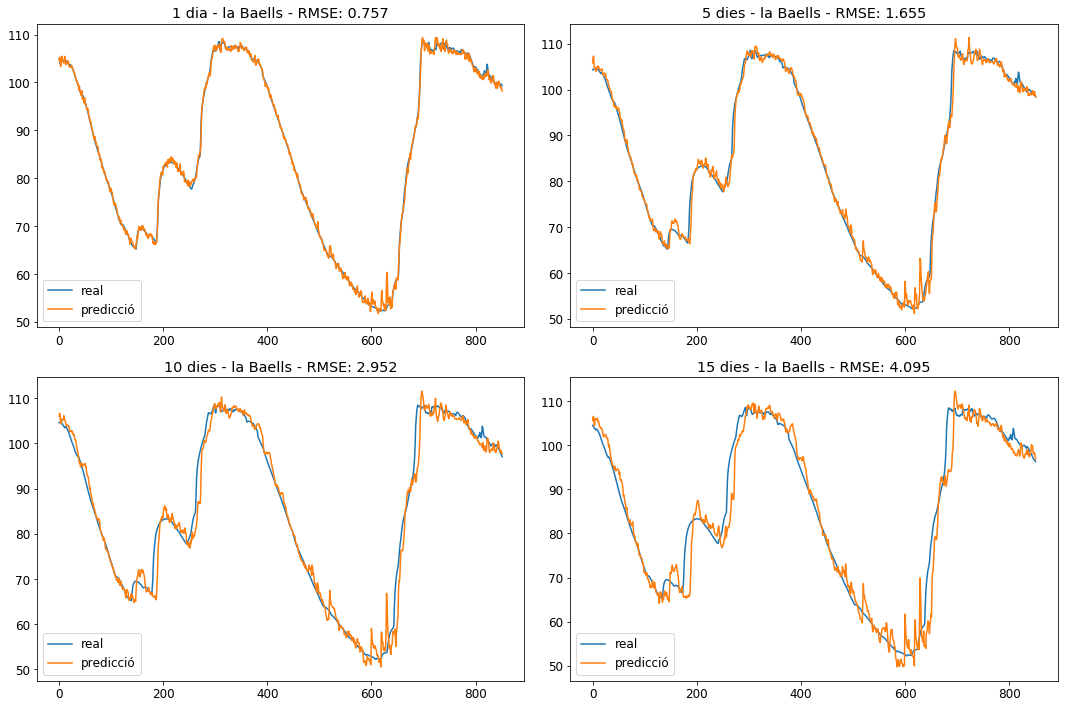

In [33]:
import matplotlib.pyplot as plt
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - la Baells - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - la Baells - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - la Baells - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - la Baells - RMSE: '+str(round(RMSE_days[14],3))

plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=3)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=3)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=3)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=3)


fig.tight_layout()
plt.show()


In [34]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('dia '+str(i+1))

headers.append('Total')
v = RMSE_days
ultim = v.append(RMSE_TOT)
table1 = tabulate([RMSE_days[0:5]], headers[0:5], tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[5:10]], headers[5:10], tablefmt="fancy_grid")
table3 = tabulate([RMSE_days[10:16]], headers[10:16], tablefmt="fancy_grid")
#output
print(table1)
print(table2)
print(table3)

╒══════════╤══════════╤═════════╤═════════╤═════════╕
│    dia 1 │    dia 2 │   dia 3 │   dia 4 │   dia 5 │
╞══════════╪══════════╪═════════╪═════════╪═════════╡
│ 0.756501 │ 0.928253 │ 1.11625 │  1.4041 │ 1.65459 │
╘══════════╧══════════╧═════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╤═════════╤══════════╕
│   dia 6 │   dia 7 │   dia 8 │   dia 9 │   dia 10 │
╞═════════╪═════════╪═════════╪═════════╪══════════╡
│ 1.91091 │ 2.16617 │ 2.43739 │ 2.70727 │  2.95233 │
╘═════════╧═════════╧═════════╧═════════╧══════════╛
╒══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   dia 11 │   dia 12 │   dia 13 │   dia 14 │   dia 15 │   Total │
╞══════════╪══════════╪══════════╪══════════╪══════════╪═════════╡
│  3.16011 │   3.3932 │  3.62324 │  3.85044 │  4.09508 │  2.6324 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧═════════╛


In [8]:
import numpy as np
n_steps_out = 15
propTrainTest = 0.8
n_steps_in = np.arange(5,15,1)
resultat = []
for entrades in n_steps_in:
    train_X, test_X, train_Y, test_Y = train_test(entrades, n_steps_out, propTrainTest, datasetN)
    n_input = train_X.shape[1] * train_X.shape[2]
    train_X = train_X.reshape((train_X.shape[0], n_input))
    test_X = test_X.reshape((test_X.shape[0], n_input))
    regr_multisvr = MultiOutputRegressor(SVR(kernel='rbf', C=85, gamma=0.0101, epsilon=0.0115))
    regr_multisvr.fit(train_X, train_Y)
    # Predict on new data
    yhat = regr_multisvr.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
    # invertim prediccions per tenir-les en l'escala original
    yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
    test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
    #dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    inv_yhat = scaler.inverse_transform(dataset2)
    testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
    #test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
    test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])
    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT, entrades)
    resultat.append((entrades, RMSE_TOT))

2.5763216096455634 5
2.553729790254883 6
2.533912492097042 7
2.520889683206922 8
2.5146289032384694 9
2.508527435887003 10
2.5160600131849047 11
2.5173467361556345 12
2.5124730054262048 13
2.516868328351341 14


In [8]:
n_steps_out = 15
propTrainTest = 0.8
n_steps_in = 10
train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, datasetN)
n_input = train_X.shape[1] * train_X.shape[2]
train_X = train_X.reshape((train_X.shape[0], n_input))
test_X = test_X.reshape((test_X.shape[0], n_input))
regr_multisvr = MultiOutputRegressor(SVR(kernel='rbf', C=85, gamma=0.0101, epsilon=0.0115))
regr_multisvr.fit(train_X, train_Y)
# Predict on new data
yhat = regr_multisvr.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
# invertim prediccions per tenir-les en l'escala original
yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
#dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
inv_yhat = scaler.inverse_transform(dataset2)
testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
#test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])
RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)


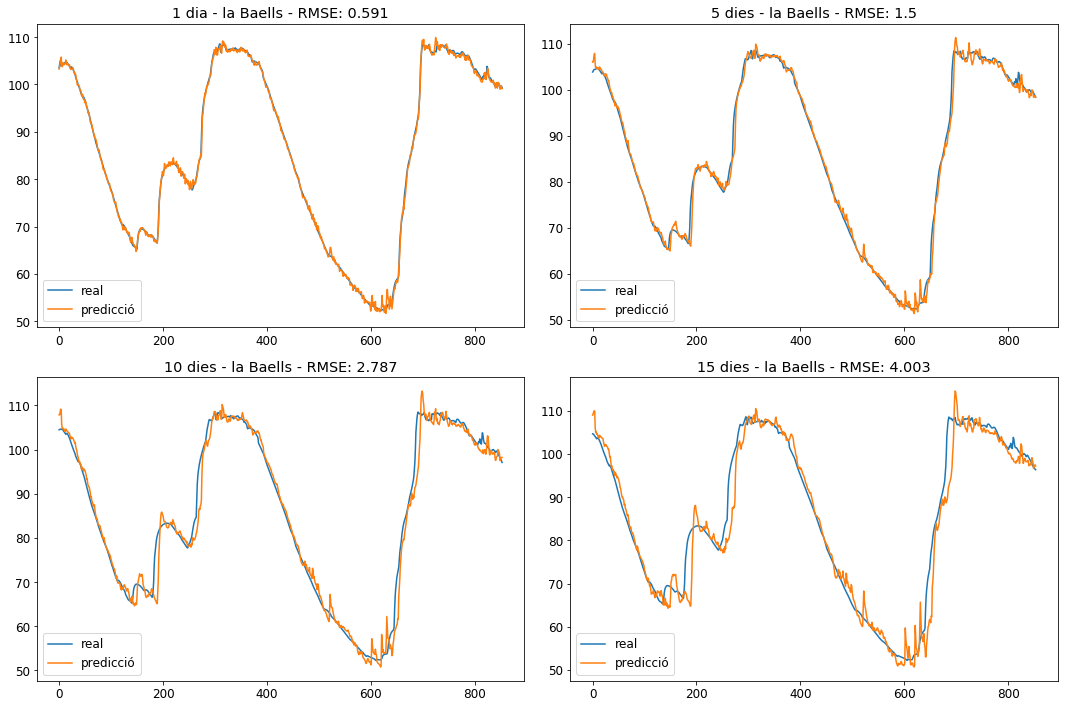

In [9]:
import matplotlib.pyplot as plt
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - la Baells - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - la Baells - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - la Baells - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - la Baells - RMSE: '+str(round(RMSE_days[14],3))

plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=3)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=3)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=3)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=3)


fig.tight_layout()
plt.show()

In [11]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('dia '+str(i+1))

headers.append('Total')
v = RMSE_days
ultim = v.append(RMSE_TOT)
table1 = tabulate([RMSE_days[0:5]], headers[0:5], tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[5:10]], headers[5:10], tablefmt="fancy_grid")
table3 = tabulate([RMSE_days[10:16]], headers[10:16], tablefmt="fancy_grid")
#output
print(table1)
print(table2)
print(table3)

╒═════════╤══════════╤══════════╤═════════╤═════════╕
│   dia 1 │    dia 2 │    dia 3 │   dia 4 │   dia 5 │
╞═════════╪══════════╪══════════╪═════════╪═════════╡
│ 0.59052 │ 0.778223 │ 0.980578 │ 1.23518 │ 1.49972 │
╘═════════╧══════════╧══════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╤═════════╤══════════╕
│   dia 6 │   dia 7 │   dia 8 │   dia 9 │   dia 10 │
╞═════════╪═════════╪═════════╪═════════╪══════════╡
│  1.7592 │ 2.00579 │ 2.27581 │ 2.53796 │  2.78746 │
╘═════════╧═════════╧═════════╧═════════╧══════════╛
╒══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   dia 11 │   dia 12 │   dia 13 │   dia 14 │   dia 15 │   Total │
╞══════════╪══════════╪══════════╪══════════╪══════════╪═════════╡
│  3.02928 │  3.25514 │  3.51018 │  3.75155 │  4.00294 │ 2.50853 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧═════════╛


In [10]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
def evaluate_forecasts_rquad(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        r_quad = r2_score(actual[:, i], predicted[:, i])
        mae = mean_absolute_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append((rmse,r_quad,mae,mse))
    # calcul global de RMSE
    s = 0
    r = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [11]:
RMSE_TOT, RMSE_days = evaluate_forecasts_rquad(test_YR,testPredict)
global_y = test_YR.reshape((test_YR.shape[0]*test_YR.shape[1], 1))
global_pred = testPredict.reshape((testPredict.shape[0]*testPredict.shape[1], 1))
r_quad = r2_score(global_y, global_pred)
rmse = sqrt(mean_squared_error(global_y, global_pred))
mse = mean_squared_error(global_y, global_pred)
mae = mean_absolute_error(global_y, global_pred)

res_globals=[rmse, r_quad, mae, mse]

resultsDF =  pd.DataFrame(RMSE_days)
resultsDF = resultsDF.T
resultsDF['Global'] = res_globals
resultsDF.columns=['dia 1','dia 2','dia 3','dia 4','dia 5','dia 6','dia 7','dia 8','dia 9','dia 10','dia 11','dia 12','dia 13','dia 14','dia 15', 'global']
resultsDF.rename(index={0:'RMSE',1:'R2',2:'MAE', 3:'MSE'}, inplace=True)
resultsDF = resultsDF.round(4)
display(resultsDF)

,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6,dia 7,dia 8,dia 9,dia 10,dia 11,dia 12,dia 13,dia 14,dia 15,global
RMSE,0.5905,0.7782,0.9806,1.2352,1.4997,1.7592,2.0058,2.2758,2.5380,2.7875,3.0293,3.2551,3.5102,3.7515,4.0029,2.5085
R2,0.9990,0.9982,0.9971,0.9954,0.9932,0.9907,0.9879,0.9844,0.9806,0.9766,0.9723,0.9680,0.9628,0.9575,0.9515,0.9811
MAE,0.4224,0.5188,0.6060,0.7309,0.8672,1.0240,1.1619,1.3155,1.4749,1.6335,1.7984,1.9398,2.1035,2.2523,2.4098,1.3506
MSE,0.3487,0.6056,0.9615,1.5257,2.2492,3.0948,4.0232,5.1793,6.4413,7.7700,9.1765,10.5959,12.3213,14.0741,16.0235,6.2927


In [12]:
RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
v = RMSE_days
ultim = v.append(RMSE_TOT)

dades_diesDF=pd.DataFrame(v)
dades_diesDF=dades_diesDF.round(3)
dades_diesDF=dades_diesDF.T
dades_diesDF.columns=['dia 1','dia 2','dia 3','dia 4','dia 5','dia 6','dia 7','dia 8','dia 9','dia 10','dia 11','dia 12','dia 13','dia 14','dia 15', 'global']
dades_diesDF.rename(index={0:'RMSE'}, inplace=True)

display(dades_diesDF)

,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6,dia 7,dia 8,dia 9,dia 10,dia 11,dia 12,dia 13,dia 14,dia 15,global
RMSE,0.591,0.778,0.981,1.235,1.5,1.759,2.006,2.276,2.538,2.787,3.029,3.255,3.51,3.752,4.003,2.509


In [13]:
resultsDF.to_csv('svm-multi-baells.csv', sep=',', encoding='utf-8')